In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-3-pdf/sample_3_pdf/cnc_router_big_user_manual.pdf
/kaggle/input/sample-3-pdf/sample_3_pdf/03 DX 200 - 3.pdf
/kaggle/input/sample-3-pdf/sample_3_pdf/dxg-series.pdf


In [2]:
!apt-get install -yq poppler-utils

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (323 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 128663 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


In [3]:
!pip install -q colpali-engine torch pymupdf numpy matplotlib einops seaborn PyPDF2 google-genai qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import os
import torch
import qdrant_client
import time
import shutil
import boto3
import os

from colpali_engine.models import ColPali, ColPaliProcessor
from pdf2image import convert_from_path
from qdrant_client.http import models
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Markdown

2025-07-25 11:19:34.243433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753442374.440420      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753442374.496748      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='../.env')

gemini_token=os.getenv('GEMINI_TOKEN')

qdrant_url=os.getenv('QDRANT_URL')
qdrant_token=os.getenv('QDRANT_TOKEN')

In [5]:
IMAGE_DIR='/kaggle/working/page_convert_image'
os.makedirs(IMAGE_DIR,exist_ok=True)

In [7]:
device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda'

In [8]:
model_name = "vidore/colpali-v1.3"

colpali_model = ColPali.from_pretrained(
                pretrained_model_name_or_path=model_name,
                torch_dtype=torch.bfloat16,
                device_map=device, 
                cache_dir="./model_cache"
            )

colpali_processor = ColPaliProcessor.from_pretrained(
                pretrained_model_name_or_path=model_name,
                cache_dir="./model_cache"
            )

adapter_config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [ ]:

client = qdrant_client.QdrantClient(
    url=qdrant_url,
    api_key=qdrant_token
)
print(client.info())
print('---------------------------------------------------------')
print(client.get_collections())

title='qdrant - vector search engine' version='1.14.1' commit='530430fac2a3ca872504f276d2c91a5c91f43fa0'
---------------------------------------------------------
collections=[]


In [10]:
COLLECTION_NAME='sample_CNC'
VECTOR_SIZE=128
client.create_collection(
    collection_name=COLLECTION_NAME,
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=VECTOR_SIZE,
        distance=models.Distance.COSINE,
        on_disk=True,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
    ),
)

True

In [11]:
os.environ["TOKENIZERS_PARALLELISM"] = "false" 

# Wrapper function to convert PDFs into a dictionary of PIL images which will be used to create embeddings
def convert_pdfs_to_images(pdf_folder):
    """Convert PDFs into a dictionary of PIL images."""
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = []

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        
        for page_num, image in enumerate(images):
            all_images.append({"doc_id": doc_id+1, "page_num": page_num+1, "image": image.convert("RGB")})

    return all_images

PDF_DIR = '/kaggle/input/sample-3-pdf/sample_3_pdf'  # Change this to your actual folder path
dataset = convert_pdfs_to_images(PDF_DIR)

In [12]:
dataset[:5]

[{'doc_id': 1,
  'page_num': 1,
  'image': <PIL.Image.Image image mode=RGB size=1700x2200>},
 {'doc_id': 1,
  'page_num': 2,
  'image': <PIL.Image.Image image mode=RGB size=1700x2200>},
 {'doc_id': 1,
  'page_num': 3,
  'image': <PIL.Image.Image image mode=RGB size=1700x2200>},
 {'doc_id': 1,
  'page_num': 4,
  'image': <PIL.Image.Image image mode=RGB size=1700x2200>},
 {'doc_id': 1,
  'page_num': 5,
  'image': <PIL.Image.Image image mode=RGB size=1700x2200>}]

In [13]:
BATCH_SIZE = 5
print("Generating embeddings and storing in Qdrant...")

with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), BATCH_SIZE):
        batch = dataset[i : i + BATCH_SIZE]

        # Extract images
        images = [item["image"] for item in batch]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(colpali_model.device)
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            points.append(
                models.PointStruct(
                    id=i + j,  # Use the batch index as the ID
                    vector=embedding.tolist(),  # Convert to list
                    payload={
                        "doc_id": batch[j]["doc_id"],
                        "page_num": batch[j]["page_num"],
                        "source": "pdf archive",
                    },  
                )
            )

        # Upload points to Qdrant
        try:
            client.upsert(collection_name=COLLECTION_NAME, points=points)
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(BATCH_SIZE)

print("Indexing complete!")

Generating embeddings and storing in Qdrant...


Indexing Progress: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Indexing complete!


In [73]:
# Step 1: Our query
query_text = "What is the tail stock Thrust for DX 200-3 in Kgf"

# Step 2: Generate embeddings for the query
with torch.no_grad():
    text_embedding = colpali_processor.process_queries([query_text]).to(colpali_model.device)  
    text_embedding = colpali_model(**text_embedding)

token_query = text_embedding[0].cpu().float().numpy().tolist()

start_time = time.time()

# Step 3: Query the vector database
query_result = client.query_points(collection_name=COLLECTION_NAME,
                                   query=token_query,
                                   limit=5,
                                   search_params=models.SearchParams(
                                   quantization=models.QuantizationSearchParams(
                                   ignore=True,
                                   rescore=True,
                                   oversampling=2.0
                                   )
                               )
                           )

print(f"Time taken = {(time.time()-start_time):.3f} s")

Time taken = 0.412 s


In [74]:
query_result.points

[ScoredPoint(id=42, version=8, score=21.565424, payload={'doc_id': 2, 'page_num': 5, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=48, version=9, score=21.027868, payload={'doc_id': 3, 'page_num': 5, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=46, version=9, score=19.401321, payload={'doc_id': 3, 'page_num': 3, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=40, version=8, score=18.260796, payload={'doc_id': 2, 'page_num': 3, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=45, version=9, score=16.171967, payload={'doc_id': 3, 'page_num': 2, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None)]

In [75]:
# Define a folder to save matched images
MATCHED_IMAGES_DIR = "matched_images"

# Delete all files and the directory itself if it exists
if os.path.exists(MATCHED_IMAGES_DIR):
    shutil.rmtree(MATCHED_IMAGES_DIR)

os.makedirs(MATCHED_IMAGES_DIR)

# Extract matched images from dataset based on query_result
matched_images = []
matched_images_path = []

for result in query_result.points:
    doc_id = result.payload["doc_id"]
    page_num = result.payload["page_num"]

    # Find the matching image in dataset
    for item in dataset:
        if item["doc_id"] == doc_id and item["page_num"] == page_num:
            matched_images.append(item["image"])
            
            # Save the matched image
            image_filename = os.path.join(MATCHED_IMAGES_DIR, f"match_doc_{doc_id}_page_{page_num}.png")
            item["image"].save(image_filename, "PNG")
            matched_images_path.append(image_filename)
            print(f"✅ Saved: {image_filename}")
            
            break  

print("\n📂 All matched images are saved in the 'matched_images' folder.")

✅ Saved: matched_images/match_doc_2_page_5.png
✅ Saved: matched_images/match_doc_3_page_5.png
✅ Saved: matched_images/match_doc_3_page_3.png
✅ Saved: matched_images/match_doc_2_page_3.png
✅ Saved: matched_images/match_doc_3_page_2.png

📂 All matched images are saved in the 'matched_images' folder.


In [76]:
def display_image_grid(images, num_cols=5, figsize=(15, 10)):
    """
    Display a grid of images using matplotlib.
    
    Args:
        images: List of images to display
        num_cols: Number of columns in the grid (default: 8)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
    """
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate needed rows
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flat  # Flatten axes array for easier iteration
    
    # Display images
    for i in range(num_cols * num_rows):
        ax = axes[i]
        if i < num_images:
            ax.imshow(images[i])
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

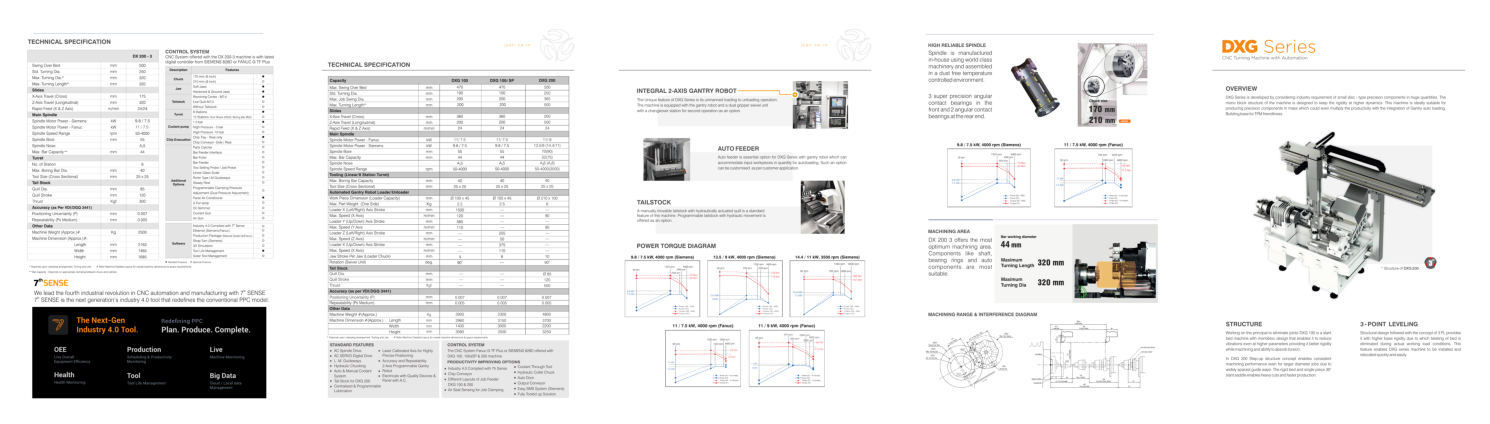

In [77]:
display_image_grid(matched_images)

In [78]:
image_result_paths=[]
for image in os.listdir('/kaggle/working/matched_images'):
    image_result_paths.append(os.path.join('/kaggle/working/matched_images',image))
image_result_paths

['/kaggle/working/matched_images/match_doc_2_page_3.png',
 '/kaggle/working/matched_images/match_doc_3_page_5.png',
 '/kaggle/working/matched_images/match_doc_3_page_3.png',
 '/kaggle/working/matched_images/match_doc_2_page_5.png',
 '/kaggle/working/matched_images/match_doc_3_page_2.png']

In [79]:
images=[Image.open(path) for path in image_result_paths]

prompt=llm_prompt = f"""You are an AI model specialized in image analysis and question answering. Below are one or more images and a query based on them.
Carefully analyze the image(s), extract relevant information, and provide a well-structured response to the query.

Query:
{query_text}

Instructions:
1. Describe the key elements or patterns observed in the image(s).
2. Use deductive reasoning to interpret the visuals in relation to the query.
3. Provide a clear and concise answer to the query with justification.
4. If applicable, highlight any assumptions or limitations.

Format your response as follows:
- Answer to Query: [Final answer]
- Reasoning: [Explain how you arrived at the answer]
- Document: [Include the document name as well as page number of the document]
"""


In [ ]:
import google.generativeai as genai
genai.configure(api_key=gemini_token)
gen_model=genai.GenerativeModel('gemini-1.5-flash')


chat=gen_model.start_chat()
response=chat.send_message([prompt,*images])
answer=response.text
print(answer)

- Answer to Query: 85 Kgf

- Reasoning: The provided document "TECHNICAL SPECIFICATION" on page 2 clearly shows the Tail Stock Thrust for the DXG 200 machine as 85 kgf.  This table lists specifications for various DXG models, and the entry for the DXG 200 (which I assume refers to the DX 200-3 in the question, given the lack of a DX 200-3 specific table) lists the Tail Stock Thrust as 85 kgf.


- Document: TECHNICAL SPECIFICATION, page 2
